In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [4]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# ImageAugment([0.2, 0.5, 0.3])


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [5]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [6]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
augmentation_weights = {"None": 1.0}



# Fasttext 1D CNN

## 512 DIMS


Epoch =  1 Loss = 0.813809 LR = 0.00022308



Epoch =  2 Loss = 0.384226 LR = 0.00044615



Epoch =  3 Loss = 0.333146 LR = 0.00066923


Exception for:  keyboard | '' '' '' | ['half_cut' 'keyboard' 'word_cutout'] argument of type 'NoneType' is not iterable

Epoch =  4 Loss = 0.325559 LR = 0.00089231
Epoch =  4 Train = 0.577986 Val = 0.560830



Epoch =  5 Loss = 0.295075 LR = 0.00099404



Epoch =  6 Loss = 0.260144 LR = 0.00094952



Epoch =  7 Loss = 0.233078 LR = 0.00086519
Epoch =  7 Train = 0.634702 Val = 0.620910



Epoch =  8 Loss = 0.228679 LR = 0.00074851



Epoch =  9 Loss = 0.206838 LR = 0.00060983
Epoch =  9 Train = 0.720068 Val = 0.708614



Epoch =  10 Loss = 0.202557 LR = 0.00046141



Epoch =  11 Loss = 0.194884 LR = 0.00031642
Epoch =  11 Train = 0.731921 Val = 0.713050



Epoch =  12 Loss = 0.188440 LR = 0.00018768



Epoch =  13 Loss = 0.185526 LR = 0.00008660



Epoch =  14 Loss = 0.185973 LR = 0.00002214
Epoch =  14 Train = 0.738851 Val = 0.718861



Epoch =  15 Loss = 0.180398 LR = 0.00000000



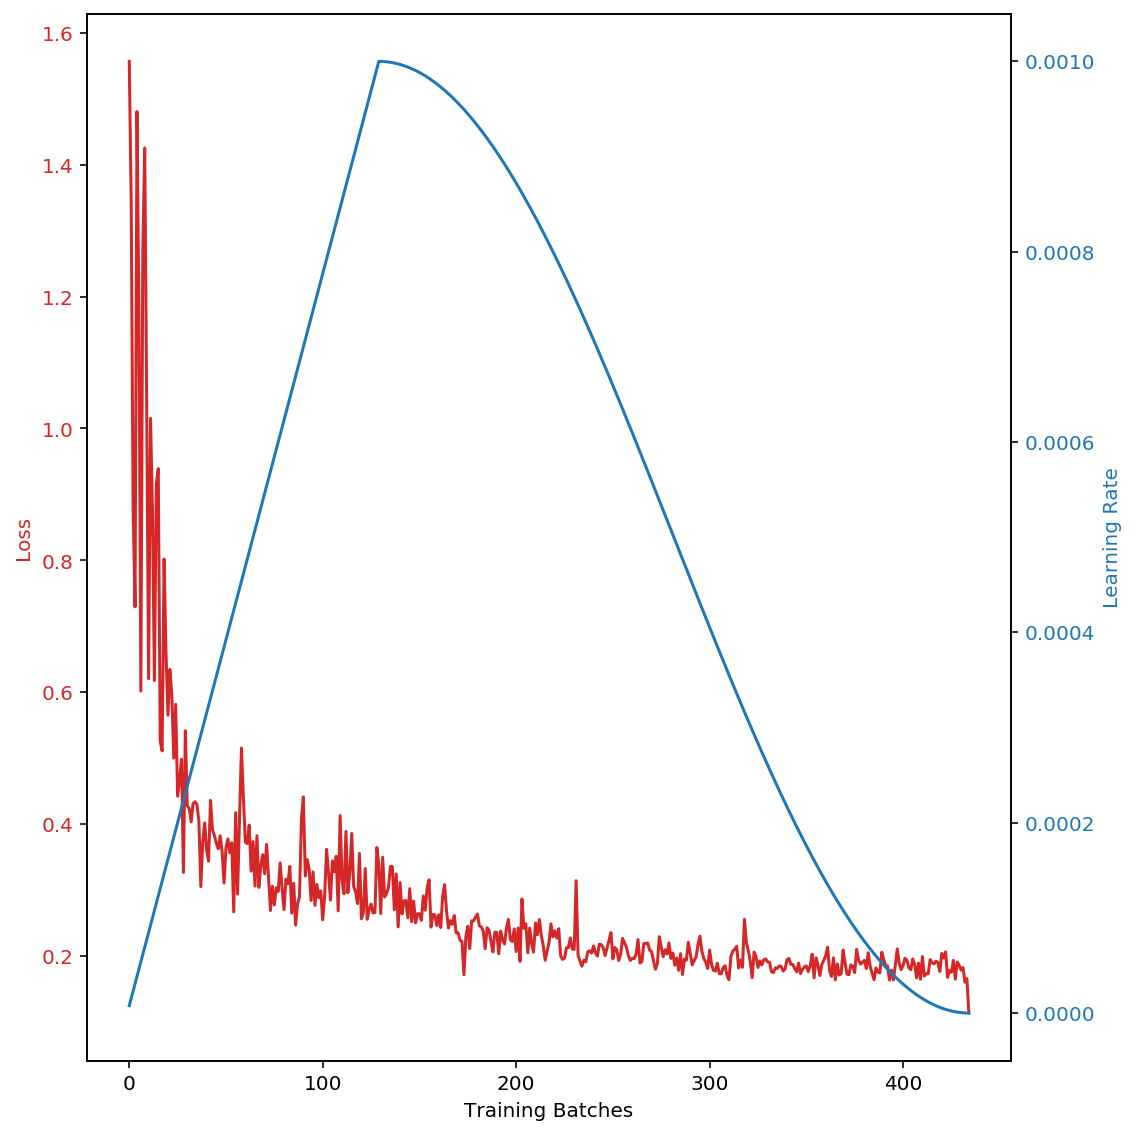

train   val
mean_or_std metric               
mean        map       0.633 0.610
            accuracy  0.698 0.666
            auc       0.739 0.719
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.779  0.731 0.754 4560.000     0.758  0.693 0.724 1140.000
pos     0.580  0.642 0.609 2640.000     0.538  0.618 0.575  660.000

In [15]:
epochs = 15
model_fn = model_builder(Fasttext1DCNNModel, 
                         dict(classifier_dims=256, num_classes=2, 
                              n_layers=2, final_layer_builder=fb_1d_loss_builder,
                              gaussian_noise=0.15, dropout=0.2, embedding_dims=256, internal_dims=512,
                             fasttext_file="crawl-300d-2M-subword.bin", featurizer="transformer",),
                         optimiser_class=optimizer, optimiser_params=optimizer_params)





multi_eval=False 
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 0.738	0.734
# 0.730	0.715
# 0.730	0.715
# 0.734	0.731
# 0.746	0.712


# Lang Features Model


Epoch =  1 Loss = 0.740931 LR = 0.00022308
Epoch =  1 Train = 0.563838 Val = 0.579006



Epoch =  2 Loss = 0.433002 LR = 0.00044615



Epoch =  3 Loss = 0.337343 LR = 0.00066923



Epoch =  4 Loss = 0.307162 LR = 0.00089231
Epoch =  4 Train = 0.572256 Val = 0.585370



Epoch =  5 Loss = 0.285020 LR = 0.00099404



Epoch =  6 Loss = 0.270794 LR = 0.00094952



Epoch =  7 Loss = 0.240145 LR = 0.00086519
Epoch =  7 Train = 0.618008 Val = 0.624373



Epoch =  8 Loss = 0.215447 LR = 0.00074851



Epoch =  9 Loss = 0.209083 LR = 0.00060983
Epoch =  9 Train = 0.698992 Val = 0.692992



Epoch =  10 Loss = 0.201586 LR = 0.00046141



Epoch =  11 Loss = 0.191093 LR = 0.00031642
Epoch =  11 Train = 0.718780 Val = 0.707232



Epoch =  12 Loss = 0.186256 LR = 0.00018768



Epoch =  13 Loss = 0.183488 LR = 0.00008660



Epoch =  14 Loss = 0.182728 LR = 0.00002214
Epoch =  14 Train = 0.729379 Val = 0.715237



Epoch =  15 Loss = 0.183267 LR = 0.00000000



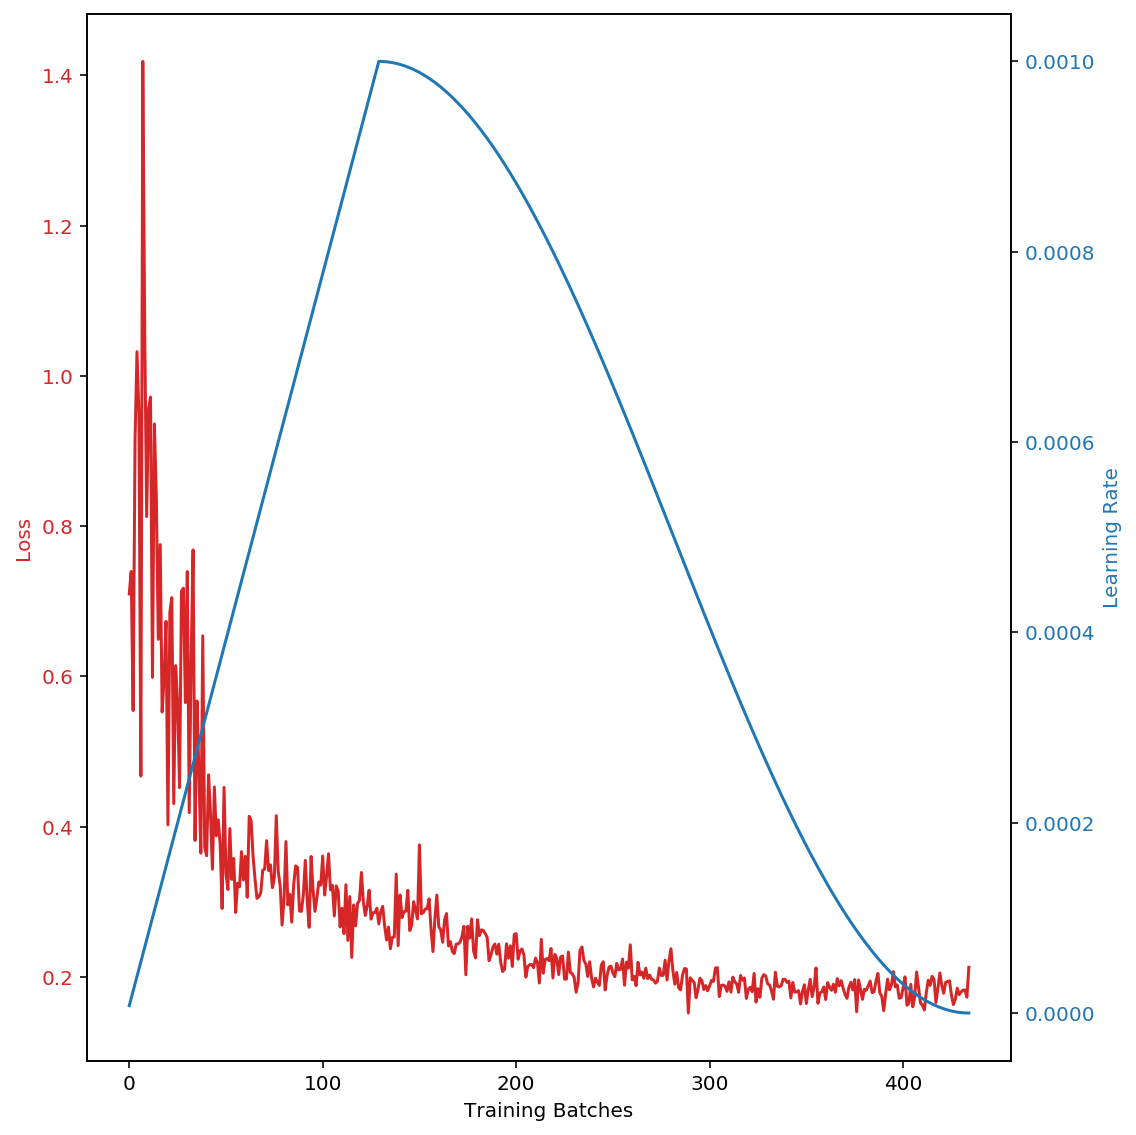

train   val
mean_or_std metric               
mean        map       0.621 0.603
            accuracy  0.680 0.664
            auc       0.730 0.716
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.773  0.699 0.734 4560.000     0.764  0.681 0.720 1140.000
pos     0.554  0.647 0.597 2640.000     0.536  0.636 0.582  660.000

In [16]:
epochs = 15
batch_size=256
# fasttext_crawl 1.9s
# spacy 1.8s
# full_view 1.4s 0.659	0.651
# gensim 7.5s # 0.718	0.737
# nltk 3s 0.609	0.585
# "spacy", "key_phrases" 4.2s 0.688	0.670
# "fasttext_crawl", "spacy", "key_phrases", "gensim" 20s 0.763	0.729 2h 49m
# "fasttext_crawl", "gensim" 11s 0.749	0.733 1h 47m
# gensim 8s 0.751	0.733 1h 20m

all_caps = ["fasttext_crawl", "spacy", "full_view", "key_phrases", "nltk", "gensim"] # "snlp", "ibm_max", "tmoji", "key_phrases", "full_view", "spacy", "nltk", "fasttext_crawl"
all_caps = ["full_view",]
all_caps = ["fasttext_crawl", "spacy", "key_phrases", "nltk"]
all_caps = ["fasttext_crawl", "gensim"]
model_fn = model_builder(LangFeaturesModel, 
                         dict(classifier_dims=256, num_classes=2, 
                              gaussian_noise=0.2, dropout=0.2, embedding_dims=256, internal_dims=512,
                              capabilities=all_caps, featurizer="transformer", n_layers=2, 
                              final_layer_builder=fb_1d_loss_builder),
                         optimiser_class=optimizer, optimiser_params=optimizer_params)



multi_eval=False
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs


# BERT Models

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.586798 LR = 0.00000007



Epoch =  2 Loss = 0.514372 LR = 0.00000014



Epoch =  3 Loss = 0.489970 LR = 0.00000021



Epoch =  4 Loss = 0.446200 LR = 0.00000028
Epoch =  4 Train = 0.615362 Val = 0.607422



Epoch =  5 Loss = 0.442560 LR = 0.00000035



Epoch =  6 Loss = 0.409569 LR = 0.00000042



Epoch =  7 Loss = 0.388268 LR = 0.00000049
Epoch =  7 Train = 0.614611 Val = 0.604885



Epoch =  8 Loss = 0.374255 LR = 0.00000056



Epoch =  9 Loss = 0.346164 LR = 0.00000062
Epoch =  9 Train = 0.612776 Val = 0.601442



Epoch =  10 Loss = 0.338203 LR = 0.00000069



Epoch =  11 Loss = 0.349688 LR = 0.00000076
Epoch =  11 Train = 0.615472 Val = 0.602489



Epoch =  12 Loss = 0.318374 LR = 0.00000083



Epoch =  13 Loss = 0.305889 LR = 0.00000090



Epoch =  14 Loss = 0.305364 LR = 0.00000097
Epoch =  14 Train = 0.625730 Val = 0.611455



Epoch =  15 Loss = 0.284016 LR = 0.00000100



Epoch =  16 Loss = 0.275478 LR = 0.00000099



Epoch =  17 Loss = 0.278850 LR = 0.00000099
Epoch =  17 Train = 0.656202 Val = 0.646254


Exception for:  keyboard | '' '' '' | ['half_cut' 'keyboard' 'word_cutout'] argument of type 'NoneType' is not iterable
Exception for:  keyboard | '' '' | ['sentence_shuffle' 'half_cut' 'word_cutout' 'keyboard' 'text_rotate'] argument of type 'NoneType' is not iterable

Epoch =  18 Loss = 0.257211 LR = 0.00000097



Epoch =  19 Loss = 0.251009 LR = 0.00000095
Epoch =  19 Train = 0.679298 Val = 0.668680



Epoch =  20 Loss = 0.243664 LR = 0.00000093



Epoch =  21 Loss = 0.233559 LR = 0.00000091



Epoch =  22 Loss = 0.230786 LR = 0.00000088



Epoch =  23 Loss = 0.208180 LR = 0.00000085
Epoch =  23 Train = 0.716704 Val = 0.700909



Epoch =  24 Loss = 0.217991 LR = 0.00000081



Epoch =  25 Loss = 0.207267 LR = 0.00000077



Epoch =  26 Loss = 0.203748 LR = 0.00000073



Epoch =  27 Loss = 0.199694 LR = 0.00000069
Epoch =  27 Train = 0.729458 Val = 0.718945



Epoch =  28 Loss = 0.187002 LR = 0.00000065



Epoch =  29 Loss = 0.188494 LR = 0.00000060



Epoch =  30 Loss = 0.187062 LR = 0.00000056



Epoch =  31 Loss = 0.184733 LR = 0.00000051
Epoch =  31 Train = 0.739647 Val = 0.720074



Epoch =  32 Loss = 0.182570 LR = 0.00000046



Epoch =  33 Loss = 0.178230 LR = 0.00000042



Epoch =  34 Loss = 0.174676 LR = 0.00000037
Epoch =  34 Train = 0.740335 Val = 0.720633



Epoch =  35 Loss = 0.175088 LR = 0.00000033



Epoch =  36 Loss = 0.174945 LR = 0.00000028



Epoch =  37 Loss = 0.168813 LR = 0.00000024
Epoch =  37 Train = 0.745628 Val = 0.724180



Epoch =  38 Loss = 0.175384 LR = 0.00000020



Epoch =  39 Loss = 0.167422 LR = 0.00000017



Epoch =  40 Loss = 0.165303 LR = 0.00000013



Epoch =  41 Loss = 0.168862 LR = 0.00000010



Epoch =  42 Loss = 0.167224 LR = 0.00000008



Epoch =  43 Loss = 0.164309 LR = 0.00000005



Epoch =  44 Loss = 0.166695 LR = 0.00000003



Epoch =  45 Loss = 0.165484 LR = 0.00000002



Epoch =  46 Loss = 0.165134 LR = 0.00000001



Epoch =  47 Loss = 0.161265 LR = 0.00000000



Epoch =  48 Loss = 0.164200 LR = 0.00000000



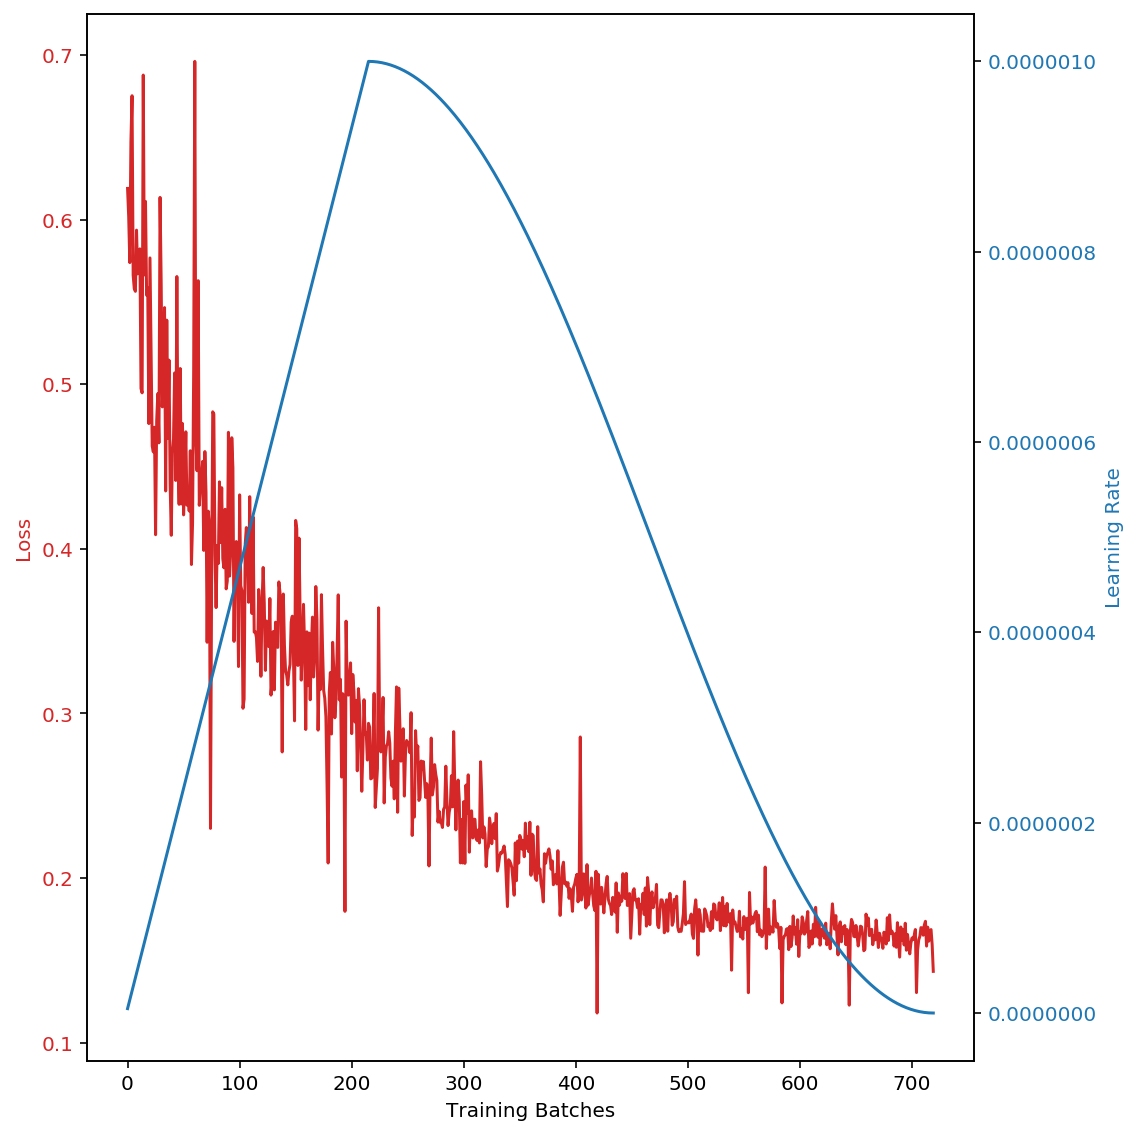

train   val
mean_or_std metric               
mean        map       0.646 0.635
            accuracy  0.715 0.711
            auc       0.751 0.727
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.761  0.803 0.781 4560.000     0.745  0.826 0.783 1140.000
pos     0.623  0.564 0.592 2640.000     0.630  0.511 0.564  660.000

In [9]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.35,
                              dropout=0.35,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37],
    show_model_stats=False,
    sampling_policy="without_replacement")
r1, p1 = results, prfs
results
prfs



# Predict

In [ ]:
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.35,
                              dropout=0.35,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


In [ ]:
epochs = 24
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, augmentation_weights, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           sampling_policy="without_replacement")
submission.to_csv("submission.csv",index=False)
submission.sample(3)


In [ ]:
submission.sample(10)